In [6]:
import torch
import torch.nn as nn
from torch.autograd import grad
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
from torch.utils import *
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import gumbel_softmax
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from plot_metrics import plot_jsd, plot_jsd_fred

In [9]:
# Or Option 2: Use absolute path
file_path = r"C:\Users\kotsgeo\Documents\GANs\GANs\AMPdata.txt"

class SequenceDataset(Dataset):
    def __init__(self, file_path, seq_length=156):
        self.seq_length = seq_length
        self.sequences = []
        self.char_to_idx = {'P': 0, 'A': 1, 'T': 2, 'G': 3, 'C': 4}
        
        # Handle both absolute and relative paths
        if not os.path.isabs(file_path):
            file_path = os.path.join(os.getcwd(), file_path)
            
        try:
            with open(file_path, 'r') as f:
                for line in f:
                    seq = line.strip().split('\t')[0]
                    if len(seq) < seq_length:
                        seq = seq + 'P' * (seq_length - len(seq))
                    seq = seq[:seq_length]
                    self.sequences.append(seq)
            print(f"Successfully loaded {len(self.sequences)} sequences")
            
        except FileNotFoundError:
            raise FileNotFoundError(f"Data file not found at: {file_path}")

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        one_hot = torch.zeros(self.seq_length, len(self.char_to_idx))
        for i, char in enumerate(seq[:self.seq_length]):
            if char in self.char_to_idx:
                one_hot[i][self.char_to_idx[char]] = 1
            else:
                one_hot[i][self.char_to_idx['P']] = 1
        return one_hot

# Test the dataset
if __name__ == "__main__":
    # You can use either relative or absolute path
    # Option 1: Relative path
    dataset = SequenceDataset("AMPdata.txt")
    
    # Option 2: Absolute path
    # dataset = SequenceDataset("/path/to/your/AMPdata.txt")

    # Print first sequence
    first_seq = dataset[0]
    print("First sequence shape:", first_seq.shape)
    print("\nMapping:", dataset.char_to_idx)

    # Create dataloader
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)

    print('\nNumber of sequences:', len(dataloader.dataset))
    
    # Check a batch
    for batch in dataloader:
        print("Batch shape:", batch.shape)
        print("\nSample from batch (showing where P padding is):")
        print(torch.argmax(batch[0], dim=1)[:10])  
        break
dataset = SequenceDataset(file_path)

Successfully loaded 2600 sequences
First sequence shape: torch.Size([156, 5])

Mapping: {'P': 0, 'A': 1, 'T': 2, 'G': 3, 'C': 4}

Number of sequences: 2600
Batch shape: torch.Size([64, 156, 5])

Sample from batch (showing where P padding is):
tensor([1, 2, 3, 3, 3, 1, 2, 2, 2, 4])
Successfully loaded 2600 sequences


In [10]:
class ResBlock(nn.Module):
    def __init__(self, hidden):
        super(ResBlock, self).__init__()
        
        self.hidden_channels = hidden // 4
        
        # Down projection
        self.down_proj = nn.Sequential(
            nn.BatchNorm1d(hidden),
            nn.ReLU(True),
            nn.Conv1d(hidden, self.hidden_channels, 1, padding=0)
        )
        
        # Main processing
        self.main_proc = nn.Sequential(
            nn.BatchNorm1d(self.hidden_channels),
            nn.ReLU(True),
            nn.Conv1d(self.hidden_channels, self.hidden_channels, 5, padding=2),
            
            nn.BatchNorm1d(self.hidden_channels),
            nn.ReLU(True),
            nn.Conv1d(self.hidden_channels, self.hidden_channels, 5, padding=2)
        )
        
        # Up projection
        self.up_proj = nn.Sequential(
            nn.BatchNorm1d(self.hidden_channels),
            nn.ReLU(True),
            nn.Conv1d(self.hidden_channels, hidden, 1, padding=0),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        h = self.down_proj(x)
        h = self.main_proc(h)
        h = self.up_proj(h)
        return x + h
    
class ImprovedGenerator(nn.Module):
    def __init__(self, n_chars, seq_len, batch_size, hidden):
        super(ImprovedGenerator, self).__init__()

        def init_weights(m):
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.orthogonal_(m.weight, gain=np.sqrt(2))
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

        self.n_chars = n_chars
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.hidden = hidden
        
        # Start from length 5
        self.bottom_length = 5
        
        # Initial projection
        self.linear = nn.Linear(128, hidden*16*self.bottom_length)
        
        # Progressive upsampling blocks
        # 5 -> 10 -> 20 -> 40 -> 80 -> 156
        self.upscale_factors = [2, 2, 2, 2, 1.95]  # Last step adjusts to reach exactly 156
        
        self.blocks = nn.ModuleList([
            # First block: maintain channels
            nn.Sequential(
                ResBlock(hidden*16),              
                nn.Upsample(scale_factor=self.upscale_factors[0], mode='nearest')  # 5 -> 10
            ),
            
            # Second block: 16ch → 8ch
            nn.Sequential(
                ResBlock(hidden*16),          
                nn.Conv1d(hidden*16, hidden*8, 1),
                nn.Upsample(scale_factor=self.upscale_factors[1])  # 10 -> 20
            ),
            
            # Third block: 8ch → 4ch
            nn.Sequential(
                ResBlock(hidden*8),           
                nn.Conv1d(hidden*8, hidden*4, 1),
                nn.Upsample(scale_factor=self.upscale_factors[2])  # 20 -> 40
            ),
            
            # Fourth block: 4ch → 2ch
            nn.Sequential(
                ResBlock(hidden*4),           
                nn.Conv1d(hidden*4, hidden*2, 1),
                nn.Upsample(scale_factor=self.upscale_factors[3])  # 40 -> 80
            ),
            
            # Fifth block: 2ch → ch
            nn.Sequential(
                ResBlock(hidden*2),           
                nn.Conv1d(hidden*2, hidden, 1),
                nn.Upsample(scale_factor=self.upscale_factors[4])  # 80 -> 156
            )
        ])
        
        # Final layers
        self.final = nn.Sequential(
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Conv1d(hidden, n_chars, 3, padding=1)
        )

        self.apply(init_weights)

    def forward(self, noise):
        # Initial projection and reshape
        output = self.linear(noise)  # [64, 5120]
        output = output.view(-1, self.hidden*16, self.bottom_length)  # [64, 1024, 5]
        
        # Through progressive blocks
        for block in self.blocks:
            output = block(output)
            
        # Final processing
        output = self.final(output)  # [64, 5, 156]
        
        # Prepare for Gumbel
        output = output.transpose(1, 2)  # [64, 156, 5]
        shape = output.size()
        output = output.contiguous()
        output = output.view(-1, self.n_chars)  # [9984, 5]
        output = gumbel_softmax(output, 0.5)
        
        return output.view(shape)  # Back to [64, 156, 5]

class UNetDiscriminator(nn.Module):
    def __init__(self, n_chars, seq_len, batch_size, hidden):
        super(UNetDiscriminator, self).__init__()

        def init_weights(m):
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.orthogonal_(m.weight, gain=np.sqrt(2))
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

        self.n_chars = n_chars
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.hidden = hidden

        # Initial projection
        self.initial_conv = nn.Conv1d(n_chars, hidden, 1)  # ch

        # Encoder
        self.enc1 = nn.Sequential(
            ResBlock(hidden),              # 64
            nn.Conv1d(hidden, hidden*2, 1),# -> 128
            nn.AvgPool1d(2)               # 156 -> 78
        )

        self.enc2 = nn.Sequential(
            ResBlock(hidden*2),           # 128
            nn.Conv1d(hidden*2, hidden*4, 1),# -> 256
            nn.AvgPool1d(2)               # 78 -> 39
        )

        self.enc3 = nn.Sequential(
            ResBlock(hidden*4),           # 256
            nn.Conv1d(hidden*4, hidden*8, 1),# -> 512
            nn.AvgPool1d(2)               # 39 -> 19
        )

        self.enc4 = nn.Sequential(
            ResBlock(hidden*8),           # 512
            nn.Conv1d(hidden*8, hidden*16, 1),# -> 1024
            nn.AvgPool1d(2)               # 19 -> 9
        )

        # Bottleneck
        self.bottleneck = ResBlock(hidden*16)  # 1024

        # Decoder
        self.dec1 = nn.Sequential(
            ResBlock(hidden*16),          # 1024
            nn.Conv1d(hidden*16, hidden*8, 1),# -> 512
            nn.Upsample(scale_factor=2)    # 9 -> 18
        )
        self.dec1_res = ResBlock(hidden*16)  # After concat (512+512=1024)

        self.dec2 = nn.Sequential(
            ResBlock(hidden*16),          # 1024
            nn.Conv1d(hidden*16, hidden*8, 1),# -> 512
            nn.Upsample(scale_factor=2)    # 19 -> 38
        )
        self.dec2_conv = nn.Conv1d(hidden*12, hidden*16, 1)  # 768->1024
        self.dec2_res = ResBlock(hidden*16)  # After concat adjust

        self.dec3 = nn.Sequential(
            ResBlock(hidden*16),          # 1024
            nn.Conv1d(hidden*16, hidden*4, 1),# -> 256
            nn.Upsample(scale_factor=2)    # 39 -> 78
        )
        self.dec3_conv = nn.Conv1d(hidden*6, hidden*8, 1)  # 384->512
        self.dec3_res = ResBlock(hidden*8)  # After concat adjust

        self.dec4 = nn.Sequential(
            ResBlock(hidden*8),           # 512
            nn.Conv1d(hidden*8, hidden*2, 1),# -> 128
            nn.Upsample(scale_factor=2)    # 78 -> 156
        )
        self.dec4_conv = nn.Conv1d(hidden*3, hidden*4, 1)  # 192->256
        self.dec4_res = ResBlock(hidden*4)  # After concat adjust

        # Global output (from bottleneck)
        self.global_output = nn.Sequential(
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),    
            nn.Flatten(),
            nn.Linear(hidden*16, 1)      
        )

        # Pixel-wise output
        self.pixel_output = nn.Conv1d(hidden*4, 1, 1)

        self.apply(init_weights)

    def pad_end(self, x, target_size):
        """Add padding at the end to reach target_size"""
        diff = target_size - x.size(2)
        if diff > 0:
            return F.pad(x, (0, diff), mode='constant', value=0)
        return x
    
    def forward(self, input):
        # Input shape: (batch_size, seq_len, n_chars)
        x = input.transpose(1, 2)  # (batch_size, n_chars, seq_len)

        # Initial projection
        x = self.initial_conv(x)  # [batch, hidden, 156]
        residuals = [x]

        # Encoder path
        x = self.enc1(x)        # -> 78
        residuals.append(x)
        x = self.enc2(x)        # -> 39
        residuals.append(x)
        x = self.enc3(x)        # -> 19
        residuals.append(x)
        x = self.enc4(x)        # -> 9

        # Bottleneck
        bottleneck = self.bottleneck(x)  # Store bottleneck output

        # Global output
        global_output = self.global_output(bottleneck)
        # global_output = torch.sigmoid(global_output)

        # Decoder path with padding and skip connections
        x = self.dec1(bottleneck)  # 9 -> 18
        x = self.pad_end(x, 19)    # pad to 19
        x = torch.cat([x, residuals.pop()], dim=1)
        x = self.dec1_res(x)

        x = self.dec2(x)           # 19 -> 38
        x = self.pad_end(x, 39)    # pad to 39
        x = torch.cat([x, residuals.pop()], dim=1)
        x = self.dec2_conv(x)      # Adjust channels
        x = self.dec2_res(x)

        x = self.dec3(x)           # 39 -> 78
        x = torch.cat([x, residuals.pop()], dim=1)
        x = self.dec3_conv(x)      # Adjust channels
        x = self.dec3_res(x)

        x = self.dec4(x)           # 78 -> 156
        x = torch.cat([x, residuals.pop()], dim=1)
        x = self.dec4_conv(x)      # Adjust channels
        x = self.dec4_res(x)

        # Pixel-wise output
        pixel_output = self.pixel_output(x)
        pixel_output = torch.sigmoid(pixel_output)
        pixel_output = pixel_output.transpose(1, 2)

        return global_output, pixel_output

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
from seq_analysis import sample_and_analyze, analyze_sequences, save_analysis
from JSD import jsd
# from FRED import FREDCalculator

# Initialize FReD calculator
# fred_calculator = FREDCalculator()

# Define results directory with absolute path
results_dir = r"C:\Users\kotsgeo\Documents\GANs\GANs\ResultsNoMix"

# Parameters
n_chars = 5
seq_len = 156
batch_size = 64
hidden_g = 64
hidden_d = 64
num_epochs = 70

generator = ImprovedGenerator(n_chars, seq_len, batch_size, hidden_g).to(device)
discriminator = UNetDiscriminator(n_chars, seq_len, batch_size, hidden_d).to(device)

d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.00001, betas=(0.5, 0.9))
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.00005, betas=(0.5, 0.9))

d_scheduler = CosineAnnealingLR(d_optimizer, T_max=num_epochs, eta_min=1e-6)
g_scheduler = CosineAnnealingLR(g_optimizer, T_max=num_epochs, eta_min=1e-6)

def format_time(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{hours:02d}:{minutes:02d}:{seconds:02d}"

def critic_loss(real_sequences, fake_sequences, gradient_penalty_coefficient=10.0):
    # Critic's score for real and fake
    real_global_scores, real_pixel_scores = discriminator(real_sequences)
    fake_global_scores, fake_pixel_scores = discriminator(fake_sequences)

    # Wasserstein component with global scores
    wasserstein_global_loss = torch.mean(fake_global_scores) - torch.mean(real_global_scores)

    # Pixel-wise loss: potentially integrate differences at pixel level as a regularizer or additional metric
    wasserstein_pixel_loss = torch.mean(fake_pixel_scores) - torch.mean(real_pixel_scores)
    
    # Gradient penalty adds Lipschitz constraint
    epsilon = torch.rand(real_sequences.size(0), 1, 1).to(real_sequences.device)
    interpolated_data = epsilon * real_sequences + (1 - epsilon) * fake_sequences

    # Ensure gradients will be tracked for `interpolated_data`
    interpolated_data.requires_grad_(True)

    interpolated_scores, _ = discriminator(interpolated_data)
    gradients = grad(
        outputs=interpolated_scores,
        inputs=interpolated_data,
        grad_outputs=torch.ones(interpolated_scores.size()).to(real_sequences.device),
        create_graph=True, retain_graph=True)[0]
    gradient_penalty = gradient_penalty_coefficient * ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    # Calculate total critic loss: combine global and pixel losses, with emphasis on primary purpose
    total_critic_loss = wasserstein_global_loss + wasserstein_pixel_loss + gradient_penalty
    return total_critic_loss, wasserstein_global_loss, wasserstein_pixel_loss

def generator_loss(fake_sequences):
    fake_global_scores, fake_pixel_scores = discriminator(fake_sequences)

    # Global loss encourages distribution overlap improvement
    g_global_loss = -torch.mean(fake_global_scores)

    # Pixel-wise loss: supports structural integrity and feature alignment
    g_pixel_loss = -torch.mean(fake_pixel_scores)

    # Total generator loss: aggregate across both layers of information
    g_loss = g_global_loss + g_pixel_loss
    return g_loss, g_global_loss, g_pixel_loss

def train(generator, discriminator, dataloader, num_epochs, d_step, critic_steps=5, g_step=1):
    # Initialize JSD score
    jsd_history = []
    # best_jsd = float('inf')
    
    # Initialize FReD score tracking
    # fred_history = []
    # best_fred = float('inf')

    # Initialize lists to store losses for each iteration
    iteration_losses = {
        'total_d_loss': [],
        'enc_loss': [],
        'dec_loss': [],
        'total_g_loss': [],
        'global_loss': [],
        'pixel_loss': []
    }

    total_iterations = 0

    # Add time tracking
    start_time = time.time()

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        # Initialize running averages
        running_losses = {
            'total_d_loss': 0,
            'total_g_loss': 0,
            'enc_loss': 0,
            'dec_loss': 0,
            'global_loss': 0,
            'pixel_loss': 0
        }
        num_batches = len(dataloader)

        # Initialize lists to store real and generated sequences for FReD calculation
        # real_seqs_for_fred = []
        # generated_seqs_for_fred = []

        for batch_idx, real_sequences in enumerate(dataloader):
            total_iterations += 1

            real_sequences = real_sequences.to(device)
            batch_size = real_sequences.size(0)

            d_loss_sum = 0
            for _ in range(d_step):
                noise = torch.randn(batch_size, 128).to(device)
                fake_sequences = generator(noise)

                # Calculate Critic Loss using Wasserstein Loss and Gradient Penalty
                loss_critic, enc_loss, dec_loss = critic_loss(real_sequences, fake_sequences)

                d_optimizer.zero_grad()
                loss_critic.backward()
                d_optimizer.step()

                d_loss_sum += loss_critic.item()

            # Average Critic Loss over d_steps
            d_loss_avg = d_loss_sum / d_step

            # Train Generator
            g_loss_sum = 0
            for _ in range(g_step):
                noise = torch.randn(batch_size, 128).to(device)
                fake_sequences = generator(noise)

                # Generator loss with Wasserstein setup
                loss_generator = generator_loss(fake_sequences)

                g_optimizer.zero_grad()
                loss_generator.backward()
                g_optimizer.step()

                g_loss_sum += loss_generator.item()

            # Average Generator Loss over g_steps
            g_loss_avg = g_loss_sum / g_step

            # Accumulate iteration losses
            iteration_losses['total_d_loss'].append(d_loss_avg)
            iteration_losses['total_g_loss'].append(g_loss_avg)
            running_losses['total_d_loss'] += d_loss_avg
            running_losses['total_g_loss'] += g_loss_avg

            # Print batch progress
            if batch_idx % 20 == 0:
                print(f'Batch [{batch_idx+1}/{num_batches}]')
                print(f'D_total_loss: {d_loss_avg:.4f}')
                print(f'G_total_loss: {g_loss_avg:.4f}\n')

        # Calculate JSD every N epochs (e.g., 5)
        if epoch % 1 == 0:
            current_jsd = jsd(generator, dataloader, num_batches=5)
            jsd_history.append(current_jsd)

        # # Calculate FReD every N epochs (e.g., 5)
        # if epoch % 1 == 0 and len(real_seqs_for_fred) > 0 and len(generated_seqs_for_fred) > 0:
        #     current_fred = fred_calculator.calculate_fred_from_sequences(
        #         real_seqs_for_fred[:min(100, len(real_seqs_for_fred))],  # Use up to 100 sequences
        #         generated_seqs_for_fred[:min(100, len(generated_seqs_for_fred))]
        #     )
        #     fred_history.append(current_fred)
                
        # Calculate time for this epoch
        epoch_time = time.time() - epoch_start_time
        total_time = time.time() - start_time

        # Print epoch averages
        avg_d_loss = running_losses['total_d_loss'] / num_batches
        avg_g_loss = running_losses['total_g_loss'] / num_batches
        print(f'Epoch [{epoch+1}/{num_epochs}] - '
              f'Epoch Time: {epoch_time:.2f}s - '
              f'Total Time: {format_time(total_time)}')
        print(f'D_total_loss: {avg_d_loss:.4f}')
        print(f'G_total_loss: {avg_g_loss:.4f}\n')
        print(f'Latest JSD Score: {current_jsd:.4f}')
        print(50 * "-")
        
        d_scheduler.step()        
        g_scheduler.step()
        
        if epoch % 2 == 0:
            generated_seqs = sample_and_analyze(generator, num_samples=5, epoch=epoch, batch_size=5, device=device)
            # Save generated sequences for analysis
            save_analysis(generated_seqs, epoch)

    return iteration_losses, total_iterations, jsd_history#, fred_history

Batch [1/40]
D_total_loss: 93.4778
G_total_loss: -1.3780

Batch [21/40]
D_total_loss: 74.1648
G_total_loss: -0.5828

Epoch [1/30] - Epoch Time: 12.98s - Total Time: 00:00:12
D_total_loss: 73.1888
G_total_loss: -0.6951

Latest JSD Score: 0.5313
--------------------------------------------------
Batch [1/40]
D_total_loss: 49.6876
G_total_loss: -0.4671

Batch [21/40]
D_total_loss: 38.3048
G_total_loss: -0.4231

Epoch [2/30] - Epoch Time: 12.98s - Total Time: 00:00:25
D_total_loss: 38.5075
G_total_loss: -0.4234

Latest JSD Score: 0.5265
--------------------------------------------------
Batch [1/40]
D_total_loss: 29.8907
G_total_loss: -0.3466

Batch [21/40]
D_total_loss: 14.2452
G_total_loss: -0.2750

Epoch [3/30] - Epoch Time: 12.83s - Total Time: 00:00:38
D_total_loss: 15.8382
G_total_loss: -0.2836

Latest JSD Score: 0.5382
--------------------------------------------------
Batch [1/40]
D_total_loss: 12.5432
G_total_loss: -0.2045

Batch [21/40]
D_total_loss: 5.2560
G_total_loss: -0.1142


c:\Users\kotsgeo\AppData\Local\Anaconda3\envs\myenv\lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\kotsgeo\AppData\Local\Anaconda3\envs\myenv\lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


KeyError: 'g_global_loss'

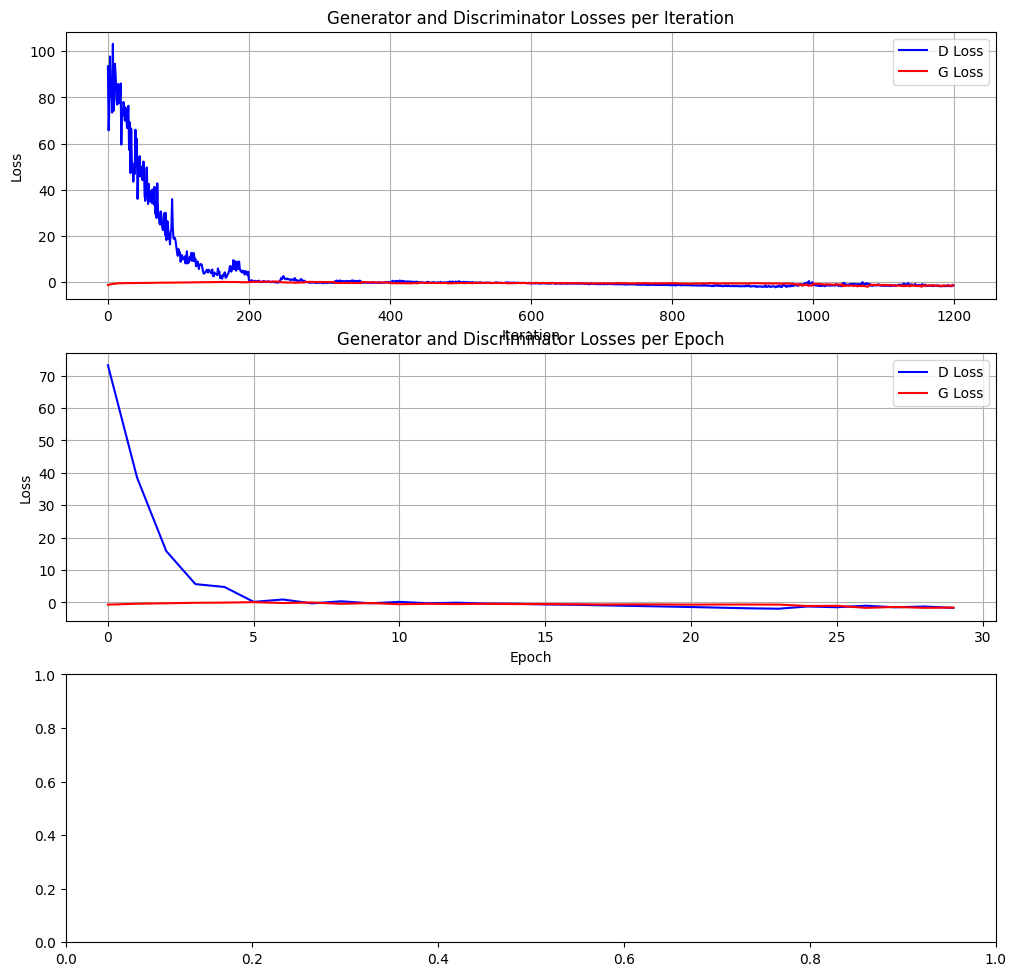

In [18]:
iteration_losses, total_iterations, jsd_history = train(generator, discriminator, dataloader,
                                                       num_epochs=30, d_step=1, g_step=1) #fred_history

plot_jsd(
    iteration_losses=iteration_losses,
    jsd_history=jsd_history,
    # fred_history=fred_history,
    total_iterations=total_iterations,
    num_epochs=30,
    dataloader_size=len(dataloader)
)